In [1]:
import numpy as np
import json
import os
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import pickle
import seaborn as sns
import pandas as pd

In [2]:
def get_models_paths(folder):
    files = os.listdir(folder)
    files.sort()
    files = ['{}/{}'.format(folder,file) for file in files if not file.startswith('.')]
    return files

In [3]:
def prepare(filepath):
    IMG_SIZE = 100  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img_array = img_array / 255
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [9]:
models_json = get_models_paths('trained_model_files/angles/JSON')
print('\n'.join('{}: {}'.format(*k) for k in enumerate(models_json)))

0: trained_model_files/angles/JSON/trained_model_angles.json
1: trained_model_files/angles/JSON/trained_model_angles_v10_DI_PA_different_neurons_Adagrad_30_.json
2: trained_model_files/angles/JSON/trained_model_angles_v11_DI_PA_different_neurons_Adadelta_2.3_.json
3: trained_model_files/angles/JSON/trained_model_angles_v12_DI_PA_different_neurons_Adamax_47_.json
4: trained_model_files/angles/JSON/trained_model_angles_v13_DI_PA_different_neurons_Nadam_0.2_.json
5: trained_model_files/angles/JSON/trained_model_angles_v14_DI_PA_different_neurons_RMSProp_35_.json
6: trained_model_files/angles/JSON/trained_model_angles_v15_DI_PA_different_neurons_SGD_26_.json
7: trained_model_files/angles/JSON/trained_model_angles_v16_DI_PA_different_neurons_and_layouts_4Conv_53_.json
8: trained_model_files/angles/JSON/trained_model_angles_v17_DI_PA_different_neurons_and_layouts_4Conv_differentFM_63_.json
9: trained_model_files/angles/JSON/trained_model_angles_v2.json
10: trained_model_files/angles/JSON/tra

In [8]:
models_h5 = get_models_paths('trained_model_files/angles/H5')
print('\n'.join('{}: {}'.format(*k) for k in enumerate(models_json)))

0: trained_model_files/angles/H5/trained_model_weights_angles.h5
1: trained_model_files/angles/H5/trained_model_weights_angles_v10_DI_PA_different_neurons_Adagrad_30_.h5
2: trained_model_files/angles/H5/trained_model_weights_angles_v11_DI_PA_different_neurons_Adadelta_2.3_.h5
3: trained_model_files/angles/H5/trained_model_weights_angles_v12_DI_PA_different_neurons_Adamax_47_.h5
4: trained_model_files/angles/H5/trained_model_weights_angles_v13_DI_PA_different_neurons_Nadam_0.2_.h5
5: trained_model_files/angles/H5/trained_model_weights_angles_v14_DI_PA_different_neurons_RMSProp_35_.h5
6: trained_model_files/angles/H5/trained_model_weights_angles_v15_DI_PA_different_neurons_SGD_26_.h5
7: trained_model_files/angles/H5/trained_model_weights_angles_v16_DI_PA_different_neurons_and_layouts_4Conv_53_.h5
8: trained_model_files/angles/H5/trained_model_weights_angles_v17_DI_PA_different_neurons_and_layouts_4Conv_differentFM_63_.h5
9: trained_model_files/angles/H5/trained_model_weights_angles_v2.h5

In [10]:
json_file = open(models_json[15], "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(models_h5[15])
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
img_path = 'im_base_to_angle/rotated_5_pa/test/30/914238d9127c47af978dc46047f97cff.png'
img = image.load_img(img_path, target_size=(100, 100))
print(img)

<PIL.Image.Image image mode=RGB size=100x100 at 0x7F6A1D898F60>


In [13]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 1024)      10240     
_________________________________________________________________
activation (Activation)      (None, 98, 98, 1024)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 1024)      0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 1024)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 512)       4719104   
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 512)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 512)       0         
__________

In [14]:
activation_model = Model(inputs=loaded_model.input, 
                         outputs=loaded_model.layers[0].output)

In [15]:
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 1024)      10240     
Total params: 10,240
Trainable params: 10,240
Non-trainable params: 0
_________________________________________________________________


In [16]:
activation = activation_model.predict(prepare(img_path))
print(activation.shape)

(1, 98, 98, 1024)


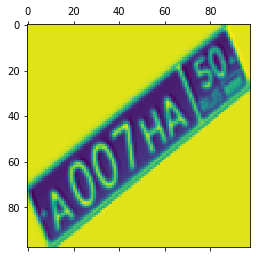

In [26]:
plt.matshow(activation[0, :, :, 4])

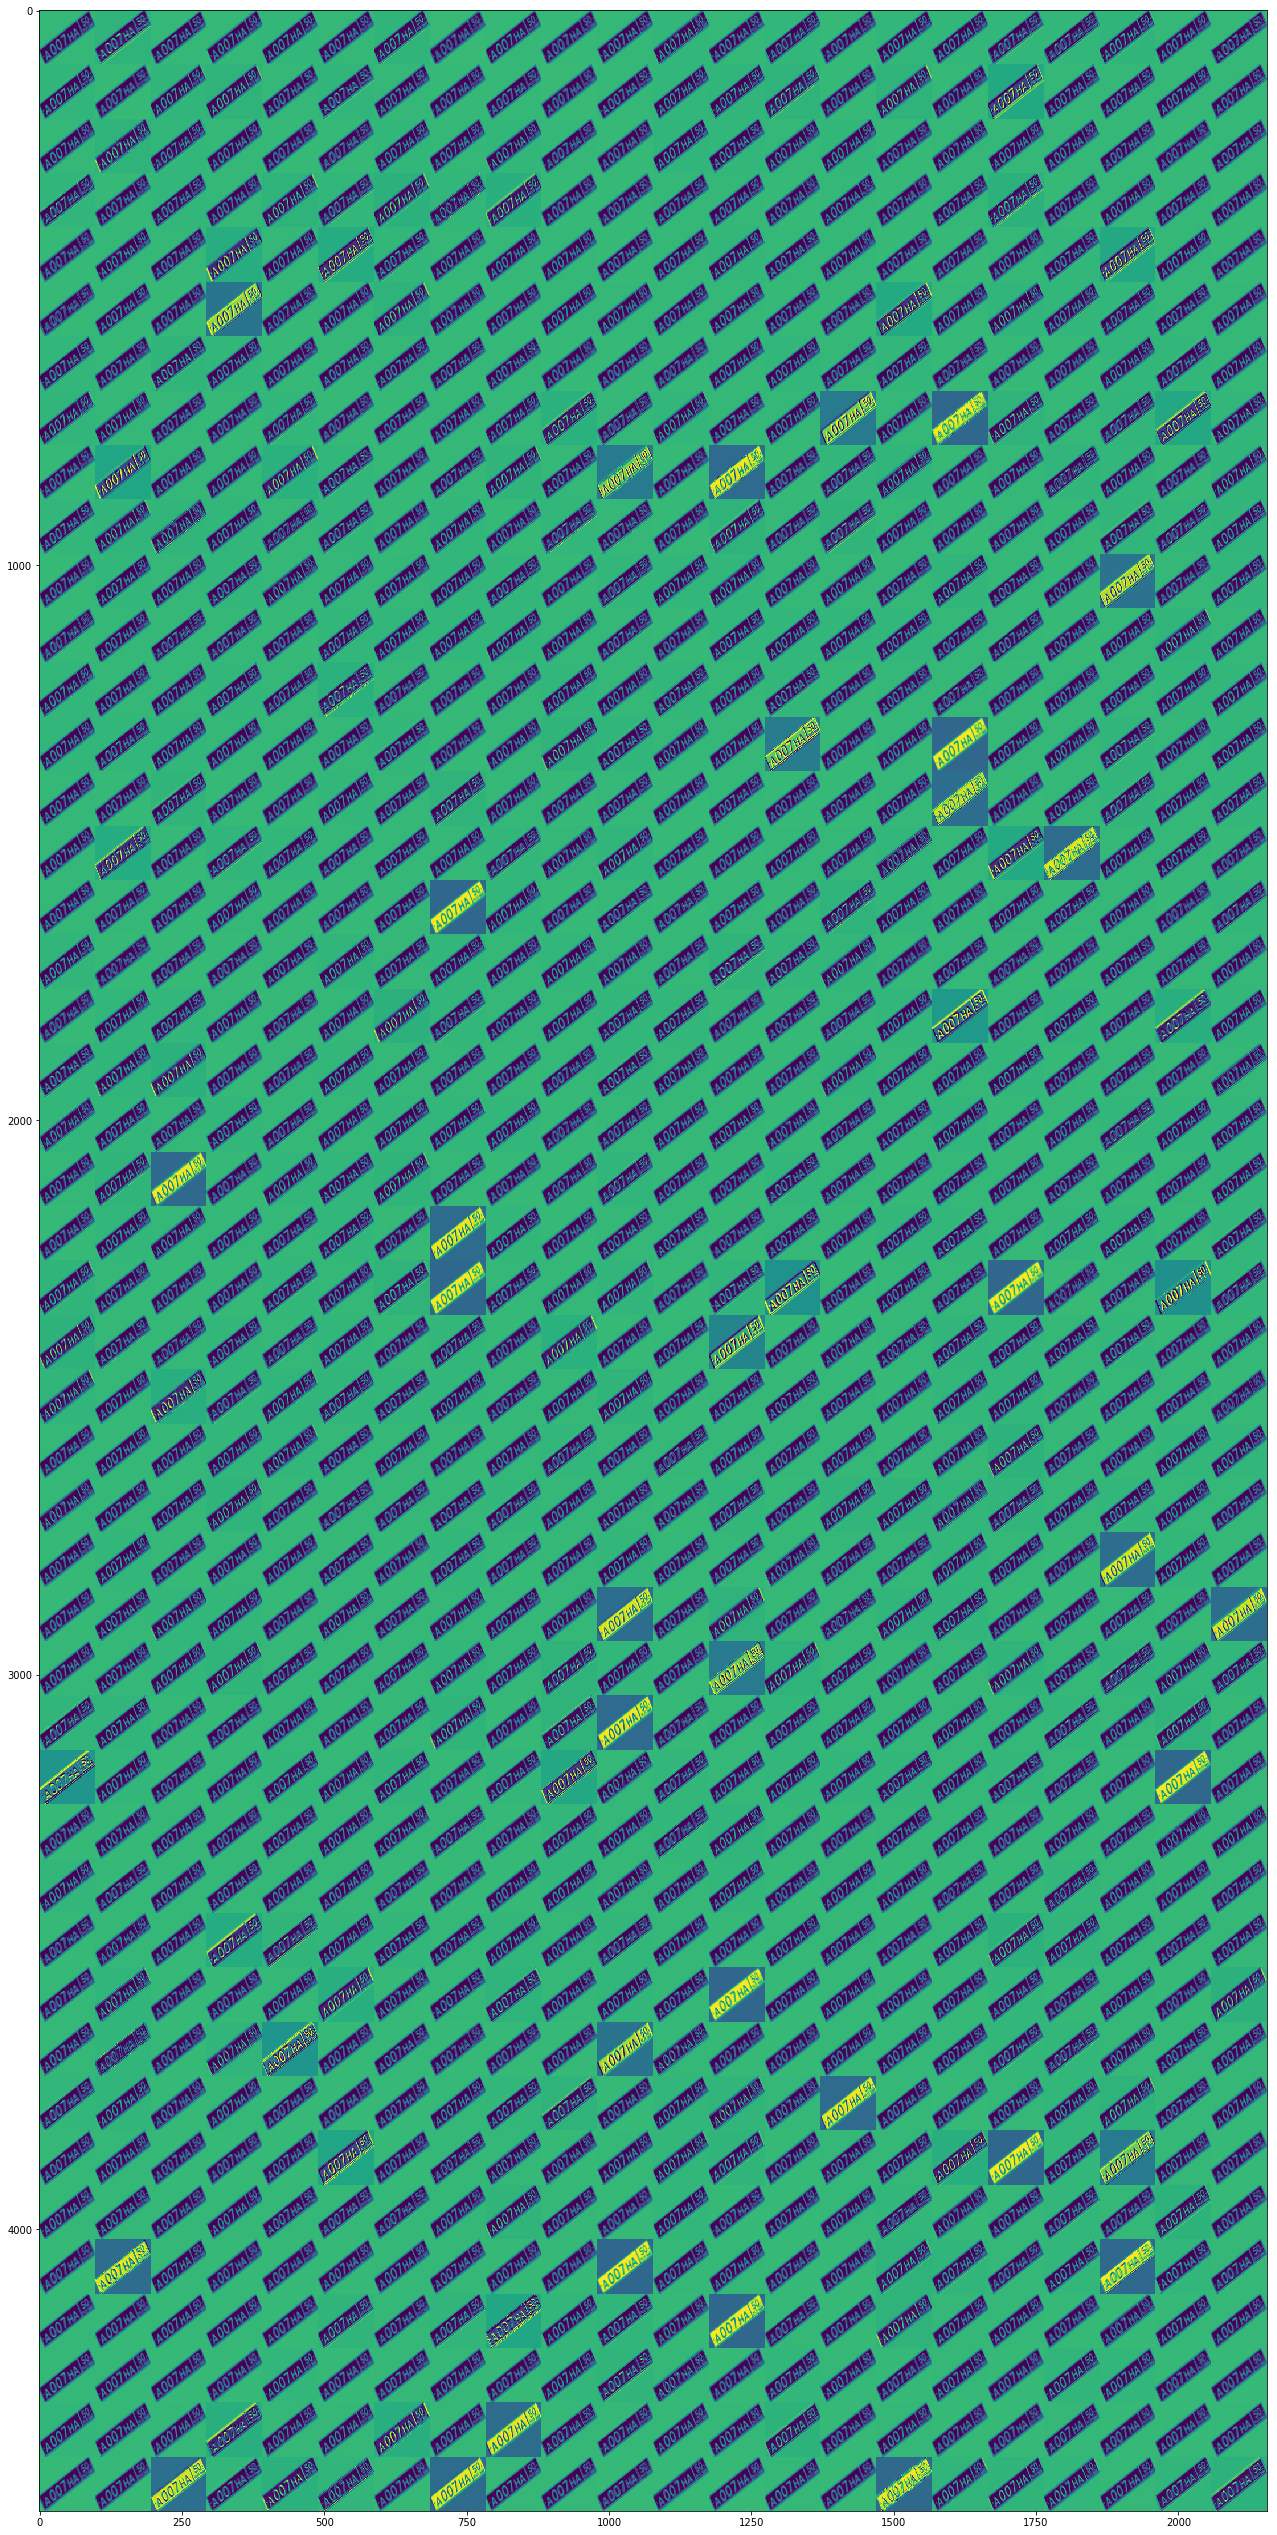

In [29]:
images_per_row = 22
n_filters = activation.shape[-1]
size = activation.shape[1]
n_cols = n_filters // images_per_row

display_grid = np.zeros((n_cols * size, images_per_row * size))

for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = activation[0, :, :, col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [30]:
activation_model = Model(inputs=loaded_model.input, 
                         outputs=loaded_model.layers[4].output)

In [31]:
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 1024)      10240     
_________________________________________________________________
activation (Activation)      (None, 98, 98, 1024)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 1024)      0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 1024)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 512)       4719104   
Total params: 4,729,344
Trainable params: 4,729,344
Non-trainable params: 0
_________________________________________________________________


In [32]:
activation = activation_model.predict(prepare(img_path))
print(activation.shape)

(1, 47, 47, 512)


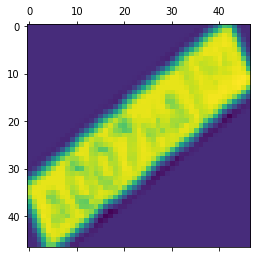

In [33]:
plt.matshow(activation[0, :, :, 0], cmap='viridis')

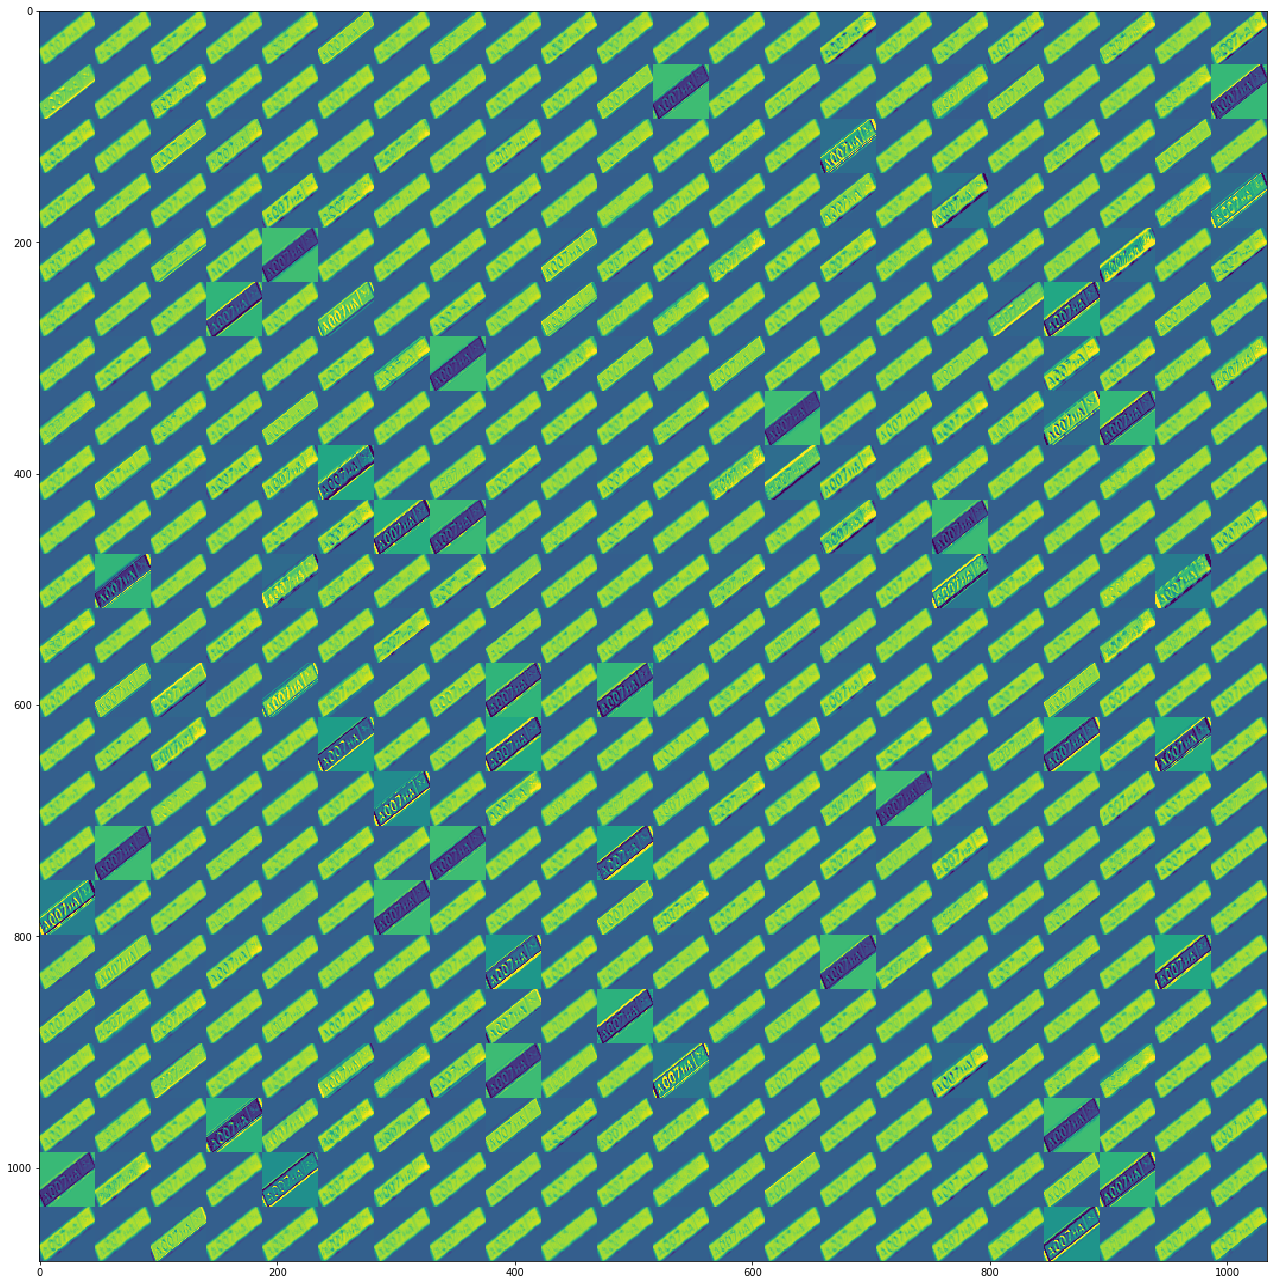

In [34]:
images_per_row = 22
n_filters = activation.shape[-1]
size = activation.shape[1]
n_cols = n_filters // images_per_row

display_grid = np.zeros((n_cols * size, images_per_row * size))

for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = activation[0, :, :, col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [35]:
activation_model = Model(inputs=loaded_model.input, 
                         outputs=loaded_model.layers[8].output)

In [36]:
activation = activation_model.predict(prepare(img_path))
print(activation.shape)

(1, 21, 21, 512)


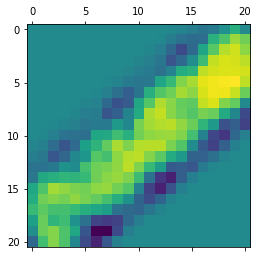

In [37]:
plt.matshow(activation[0, :, :, 18], cmap='viridis')

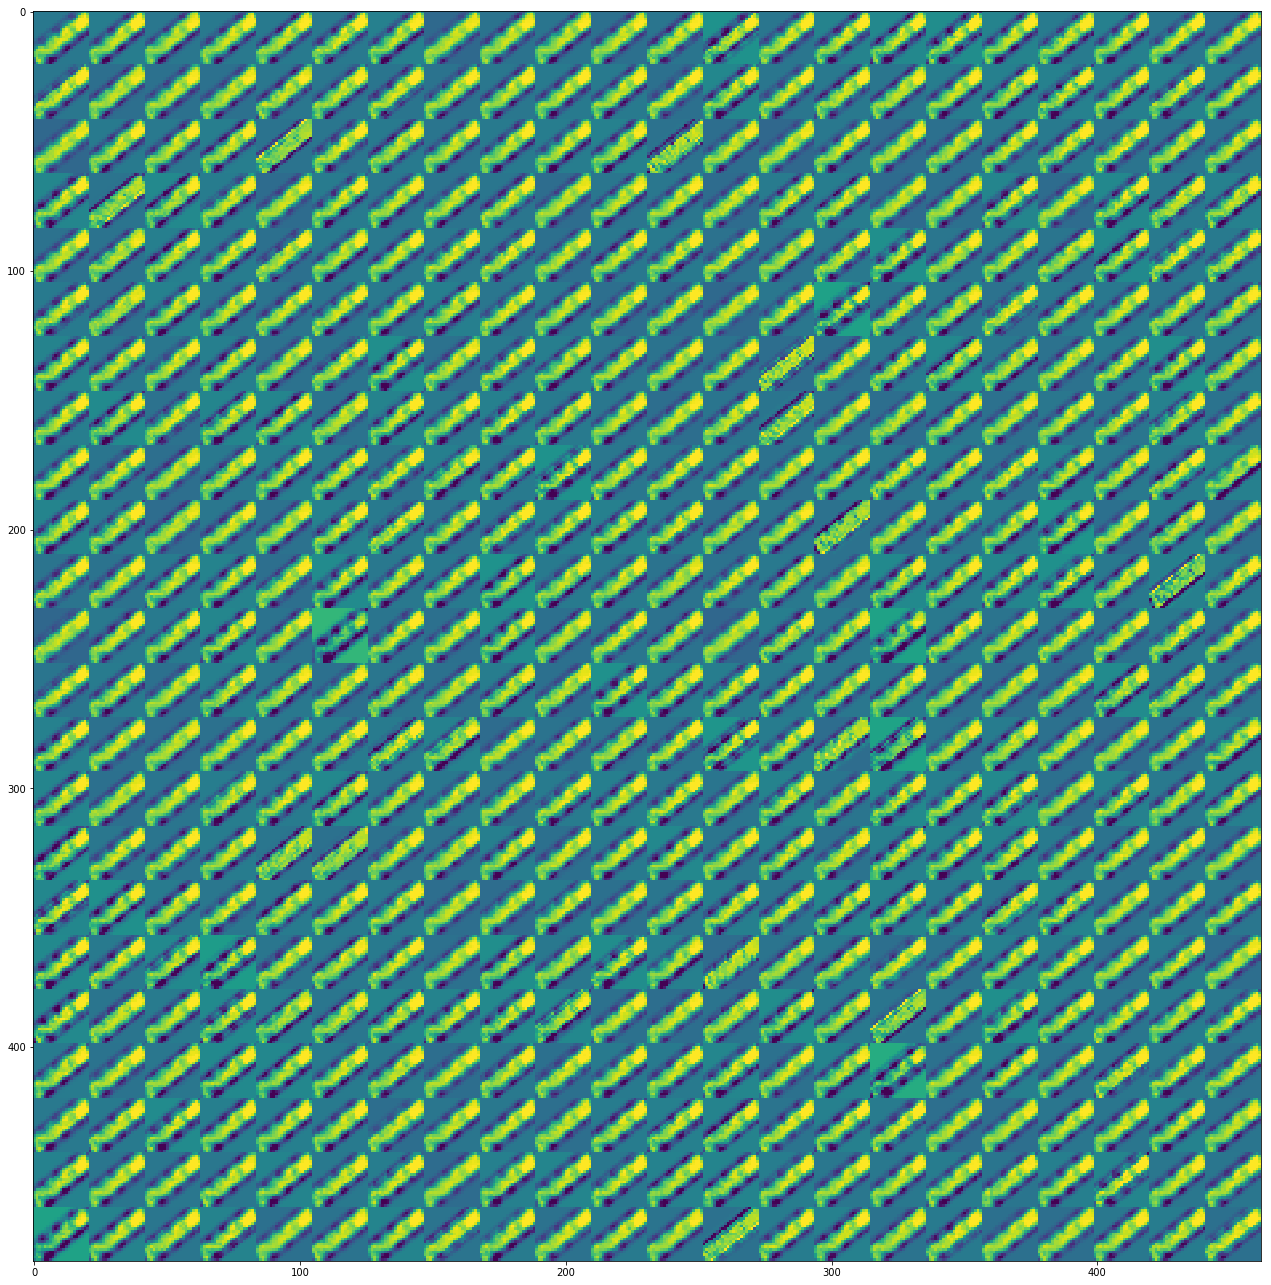

In [38]:
images_per_row = 22
n_filters = activation.shape[-1]
size = activation.shape[1]
n_cols = n_filters // images_per_row

display_grid = np.zeros((n_cols * size, images_per_row * size))

for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = activation[0, :, :, col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')